## Load Dataset and Import Libraries

In [119]:
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import mido
from mido import MidiFile, bpm2tempo, tick2second
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import numpy as np
import pygame
import time

In [3]:
# Directory where the raw data will be extracted
raw_data_extracted = 'raw_data_unzipped'

#### Clean Data

In [6]:
# Function to delete a directory and its contents
def delete_dir(dir_to_delete):
    try:
        file_count = sum([len(files) for r, d, files in os.walk(dir_to_delete)])
        shutil.rmtree(dir_to_delete)
        print(f"Directory {dir_to_delete} and all its contents ({file_count} files) have been successfully deleted.")
    except Exception as e:
        print(f"An error occurred while trying to delete the directory: {e}")

# This is in case of testing and if the initial raw files need to be deleted. 
delete_dir(raw_data_extracted)

Directory raw_data_unzipped and all its contents (7171 files) have been successfully deleted.


In [8]:
# Function to unzip a file
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

raw_data_zip = 'raw_data/midi_classic_music_data.zip'
raw_data_extracted = unzip_file(raw_data_zip, raw_data_extracted)

display(f"Extracted to: {raw_data_extracted}")

'Extracted to: raw_data_unzipped'

In [10]:
# Function to move contents of a directory up one level
def move_contents_up_one_dir(path):
    path = os.path.abspath(path)
    parent_dir = os.path.dirname(path)
    if path == parent_dir or not os.path.exists(path):
        print("Operation not allowed or path does not exist.")
        return
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), os.path.join(parent_dir, item))
    os.rmdir(path)
    print(f"All contents moved from {path} to {parent_dir} and directory removed.")

move_contents_up_one_dir(os.path.join(raw_data_extracted, 'midiclassics'))

All contents moved from /Users/busyness/raw_data_unzipped/midiclassics to /Users/busyness/raw_data_unzipped and directory removed.


In [12]:
# Function to rename .MID files to .mid
def rename_mid_files(directory):
    rename_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.MID'):
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, file[:-4] + '.mid')
                os.rename(old_file_path, new_file_path)
                rename_count += 1
                # print(f'Renamed: {old_file_path} to {new_file_path}')
    return rename_count

# Function to delete .zip files
def delete_zip_files(directory):
    delete_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                delete_count += 1
                # print(f'Deleted: {file_path}')
    return delete_count

# Rename .MID files to .mid
renamed_files_count = rename_mid_files(raw_data_extracted)
print(f'Total .MID files renamed: {renamed_files_count}')

# Delete .zip files
deleted_files_count = delete_zip_files(raw_data_extracted) 
print(f'Total .zip files deleted: {deleted_files_count}')

Total .MID files renamed: 732
Total .zip files deleted: 31


## Data Pre-Processing

In [15]:
# Function to Categorize Files by Directory
def categorize_files_by_dir(path):
    files_and_dirs = os.listdir(path)
    directories = {name for name in files_and_dirs if os.path.isdir(os.path.join(path, name))}
    file_dict = {}
    unassigned_files = {}

    for file_name in files_and_dirs:
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.mid'):
            first_word = file_name.split()[0]
            if first_word in directories:
                if first_word not in file_dict:
                    file_dict[first_word] = []
                file_dict[first_word].append(file_name)
            else:
                if first_word not in unassigned_files:
                    unassigned_files[first_word] = []
                unassigned_files[first_word].append(file_name)

    return file_dict, unassigned_files, sorted(directories)

# Function to Display Information about Categorized and Unassigned Files
def display_info(categorized_files, unassigned_files):
    print("Categorized Files Summary:")
    for key, files in categorized_files.items():
        print(f"Artist '{key}': {len(files)} files")
    
    print("\nUnassigned Files Summary:")
    if unassigned_files:
        for key, files in unassigned_files.items():
            print(f"Artist '{key}': {len(files)} files")
    else:
        print("No unassigned files found.")

# Categorize files
categorized_files, unassigned_files, all_artists = categorize_files_by_dir(raw_data_extracted)

print("Categorized Files Summary:")
for key, files in categorized_files.items():
    print(f"Artist {key}: {len(files)} files")

print("\nUnassigned Files Summary:")
for key, files in unassigned_files.items():
    print(f"Artist {key}: {len(files)} files")

Categorized Files Summary:
Artist Liszt: 7 files
Artist Tchaikovsky: 13 files
Artist Ginastera: 1 files
Artist Kuhlau: 5 files
Artist Debussy: 4 files
Artist Dvorak: 6 files
Artist Grieg: 2 files
Artist Bartok: 2 files
Artist Sibelius: 1 files
Artist Wagner: 1 files

Unassigned Files Summary:
Artist Rothchild: 11 files
Artist Diabelli: 11 files
Artist Bizet: 5 files
Artist Tchaicovsky: 1 files
Artist Reinecke: 3 files
Artist Buxethude: 13 files
Artist Gershuin: 1 files
Artist Nicolai: 1 files
Artist Rimsky: 1 files
Artist Rothchlid: 1 files
Artist meditation: 1 files
Artist Pollen: 1 files
Artist Pachebel: 5 files
Artist C.P.E.Bach: 1 files
Artist Reger: 3 files
Artist Lizt: 1 files


#### Correct File Placement

In [18]:
# Correct File Placement
corrections_to_file_placement = {
    'Pachebel': 'Pachelbel',
    'Lizt': 'Liszt'
}

for old_key, new_key in corrections_to_file_placement.items():
    if old_key in unassigned_files:
        unassigned_files[new_key] = unassigned_files.pop(old_key)

In [20]:
# Function to Move Folder Contents
def move_folder_contents(src_folder, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    for item in os.listdir(src_folder):
        src_item = os.path.join(src_folder, item)
        dest_item = os.path.join(dest_folder, item)
        
        if os.path.isdir(src_item):
            shutil.move(src_item, dest_folder)
        else:
            shutil.move(src_item, dest_item)
    
    # Delete the source folder regardless of its contents
    delete_dir(src_folder)

# Correct misnamed folders and move contents accordingly
name_corrections_folder = {
    "Albe'niz": "Albeniz",
    "Albe╠üniz": "Albeniz",
    "Mendelsonn": "Mendelssohn",
    "Tchakoff": "Tchaikovsky",
    "Handel": "Handel",
    "Haendel": "Handel",
    "Straus": "Strauss",
    "Strauss, J": "Strauss"
}

In [22]:
for src_folder, dest_folder in name_corrections_folder.items():
    src_path = os.path.join(raw_data_extracted, src_folder)
    dest_path = os.path.join(raw_data_extracted, dest_folder)
    print(f"Moving contents from {src_path} to {dest_path}...")
    move_folder_contents(src_path, dest_path)

print("Folder contents moved and directories deleted successfully.")

Moving contents from raw_data_unzipped/Albe'niz to raw_data_unzipped/Albeniz...
Directory raw_data_unzipped/Albe'niz and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped/Albe╠üniz to raw_data_unzipped/Albeniz...
Directory raw_data_unzipped/Albe╠üniz and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped/Mendelsonn to raw_data_unzipped/Mendelssohn...
Directory raw_data_unzipped/Mendelsonn and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped/Tchakoff to raw_data_unzipped/Tchaikovsky...
Directory raw_data_unzipped/Tchakoff and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped/Handel to raw_data_unzipped/Handel...
Directory raw_data_unzipped/Handel and all its contents (1 files) have been successfully deleted.
Moving contents from raw_data_unzipped/Haendel to raw_data_unzipped/Handel...
Directory raw

#### Move Files to Directories

In [25]:
# Function to move files to their respective directories
def move_files_to_directories(base_path, files_to_move):
    for directory, files in files_to_move.items():
        dir_path = os.path.join(base_path, directory)
        # Create directory if it doesn't exist
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        # Move each file to the new directory
        for file_name in files:
            shutil.move(os.path.join(base_path, file_name), os.path.join(dir_path, file_name))

# Move categorized and unassigned files to their respective directories
move_files_to_directories(raw_data_extracted,categorized_files)
move_files_to_directories(raw_data_extracted,unassigned_files)

# Print the final structure of directories
print({name for name in os.listdir(raw_data_extracted) if os.path.isdir(os.path.join(raw_data_extracted, name))})

{'Laurent', 'Ginastera', 'Albeniz', 'Arensky', 'Holst, M', 'Sarasate', 'Ambroise', 'Rothchild', 'Bartok', 'Copland', 'Lemire', 'Sinding', 'Grieg', 'Cons', 'Coleridge-Taylor', 'Sibelius', 'Peterson-Berger', 'Taube', 'Buxethude', 'Gottschalk', 'Herold', 'Grainger', 'Thomas', 'Czibulka', 'Haydn', 'Ganne', 'Stravinski', 'Hiller', 'Chabrier', 'Tarrega', 'Skriabin', 'Schoenberg', 'Mehul', 'Ivanovici', 'Poulenc', 'Hummel', 'Busoni', 'Rothchlid', 'Shostakovich', 'Paradisi', 'Resch', 'Chasins', 'Buxehude', 'Czerny', 'Kuhlau', 'Becker', 'Rossini', 'Vaughan', 'Botsford', 'Friedman', 'Jensen', 'Suppe', 'Fucick', 'Rimsky', 'Mussorgski', 'Bach', 'Lange', 'Saint-Saens', 'Komzak', 'Liszt', 'Coates', 'Field', 'Sudds', 'Reinecke', 'Berlin', 'Paganini', 'Tchaicovsky', 'Mendelssohn', 'Debussy', 'Verdi', 'Dussek', 'German', 'Durand, MA', 'Clarke', 'Paderewski', 'Wolf', 'MacBeth', 'Heidrich', 'Lecuona', 'Prokofiev', 'Lyssenko', 'Scarlatti', 'Rachmaninov', 'Brahms', 'Wagner', 'Sullivan', 'Gershuin', 'Reger',

Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


<Figure size 1000x600 with 0 Axes>

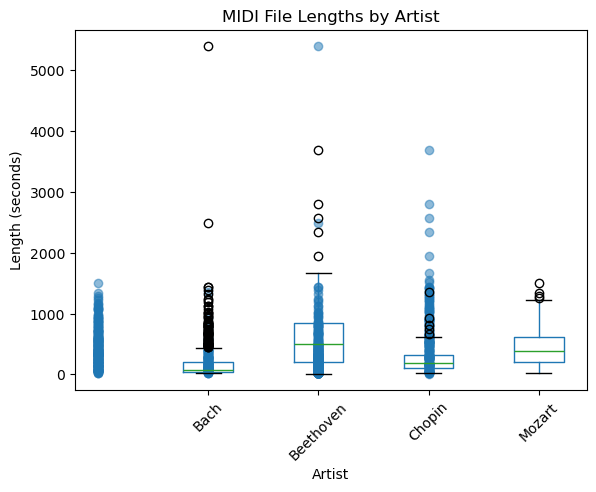

In [27]:
# Function to calculate the length of a MIDI file
def calculate_midi_length(file_path):
    try:
        midi_file = MidiFile(file_path)
        total_time = 0.0

        for track in midi_file.tracks:
            current_time = 0.0
            tempo = bpm2tempo(120)  # Default tempo is 120 BPM
            for msg in track:
                if msg.is_meta and msg.type == 'set_tempo':
                    tempo = msg.tempo
                current_time += tick2second(msg.time, midi_file.ticks_per_beat, tempo)
            if current_time > total_time:
                total_time = current_time

        return total_time
    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Define the base directory and artists
base_directory = raw_data_extracted

# Required Composers
specific_artists = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
midi_lengths = {}

# Recursively walk through the directories and calculate lengths
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, base_directory)
            for artist in specific_artists:
                if artist in relative_path:
                    midi_length = calculate_midi_length(file_path)
                    if midi_length is not None:
                        midi_lengths[relative_path] = midi_length
                    break

# Create a DataFrame for plotting
data = {'Artist': [], 'Length': []}
for path, length in midi_lengths.items():
    for artist in specific_artists:
        if artist in path:
            data['Artist'].append(artist)
            data['Length'].append(length)
            break

df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(10, 6))
df.boxplot(by='Artist', column=['Length'], grid=False)
plt.scatter(df['Artist'], df['Length'], alpha=0.5)
plt.title('MIDI File Lengths by Artist')
plt.suptitle('')
plt.xlabel('Artist')
plt.ylabel('Length (seconds)')
plt.xticks(rotation=45)
plt.show()

In [145]:
# Function to walk through directories and calculate MIDI lengths for a specific artist
def get_midi_lengths_for_artist(artist_directory):
    midi_lengths = {}
    file_count = 0
    
    for root, dirs, files in os.walk(artist_directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_directory)
                midi_length = calculate_midi_length(file_path)
                if midi_length is not None:
                    midi_lengths[relative_path] = midi_length
                    file_count += 1
    
    return midi_lengths, file_count

base_directory = raw_data_extracted
specific_artists = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold all results
all_midi_lengths = {}
artist_file_counts = {}

# Get the MIDI lengths and file counts for each artist
for artist in specific_artists:
    artist_directory = os.path.join(base_directory, artist)
    midi_lengths, file_count = get_midi_lengths_for_artist(artist_directory)
    all_midi_lengths.update(midi_lengths)
    artist_file_counts[artist] = file_count

Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [33]:
# Print the count of MIDI files for each artist
for artist, count in artist_file_counts.items():
    print(f"{artist}: {count} MIDI files")

Bach: 1024 MIDI files
Beethoven: 212 MIDI files
Chopin: 136 MIDI files
Mozart: 256 MIDI files


<Figure size 1200x800 with 0 Axes>

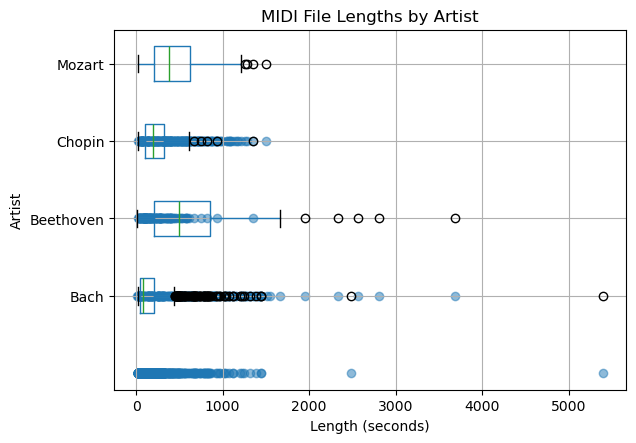

In [35]:
# Create the initial DataFrame directly from the dictionary
midi_file_lengths_df = pd.DataFrame(list(all_midi_lengths.items()), columns=['Path', 'Length'])
midi_file_lengths_df['Artist'] = midi_file_lengths_df['Path'].apply(lambda x: next((artist for artist in specific_artists if artist in x), 'Unknown'))

# Create horizontal box plots
plt.figure(figsize=(12, 8))
midi_file_lengths_df.boxplot(by='Artist', column=['Length'], vert=False)
plt.scatter(midi_file_lengths_df['Length'], midi_file_lengths_df['Artist'], alpha=0.5)
plt.title('MIDI File Lengths by Artist')
plt.suptitle('')
plt.xlabel('Length (seconds)')
plt.ylabel('Artist')
plt.yticks(rotation=0)
plt.show()

#### Temple Change Augmentation to handle class imbalance.

In [197]:
# Data Augmentation (Pitch Shifting)
def augment_midi_pitch_shift(file_path, output_dir, shift=2):
    try:
        midi_file = MidiFile(file_path)
        new_midi_file = MidiFile()

        for track in midi_file.tracks:
            new_track = mido.MidiTrack()
            new_midi_file.tracks.append(new_track)
            for msg in track:
                if msg.type == 'note_on' or msg.type == 'note_off':
                    msg.note = min(max(msg.note + shift, 0), 127)
                new_track.append(msg)

        output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.mid', f'_pitch_{shift}.mid'))
        new_midi_file.save(output_path)

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")

augmented_pitch_dir = os.path.join(raw_data_extracted, 'augmented_pitch')
os.makedirs(augmented_pitch_dir, exist_ok=True)

for root, dirs, files in os.walk(raw_data_extracted):
    for file in files:
        if file.endswith('.mid'):
            if 'Beethoven' in os.path.join(root, file) or 'Chopin' in os.path.join(root, file) or 'Mozart' in os.path.join(root, file):
                augment_midi_pitch_shift(os.path.join(root, file), augmented_pitch_dir, shift=2)
                augment_midi_pitch_shift(os.path.join(root, file), augmented_pitch_dir, shift=-2)

Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


## Feature Extraction

Features to be extracted from MIDI files:
- length
- num_notes
- note_freq
- tempo_changes
- velocities
- time_sigs
- key_sigs
- polyphony


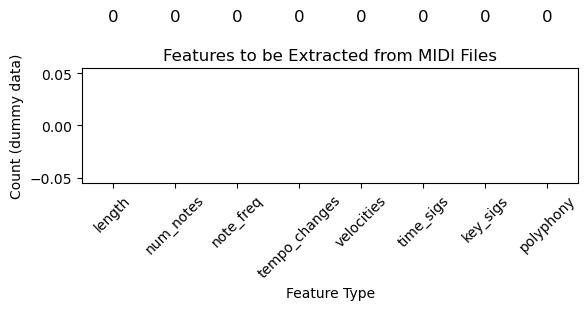

In [198]:
# Feature Extraction
features_to_extract = ['length', 'num_notes', 'note_freq', 'tempo_changes', 'velocities', 'time_sigs', 'key_sigs', 'polyphony']

print("Features to be extracted from MIDI files:")
for feature in features_to_extract:
    print(f"- {feature}")

example_feature_data = {
    'feature': features_to_extract,
    'count': [0] * len(features_to_extract)
}

example_df = pd.DataFrame(example_feature_data)

# Enhanced bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='feature', y='count', data=example_df, palette='viridis')
plt.title('Features to be Extracted from MIDI Files', fontsize=12)
plt.xlabel('Feature Type', fontsize=10)
plt.ylabel('Count (dummy data)', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add count labels on top of bars
for index, row in example_df.iterrows():
    plt.text(index, row['count'] + 0.1, f"{row['count']}", color='black', ha="center", fontsize=12)

plt.tight_layout()
plt.show()

#### Extract Features Function

In [199]:
# Feature Extraction
def extract_features(file_path):
    try:
        midi_file = MidiFile(file_path)
        features = {
            'length': 0,
            'num_notes': 0,
            'note_freq': Counter(),
            'tempo_changes': [],
            'velocities': [],
            'time_sigs': Counter(),
            'key_sigs': Counter(),
            'polyphony': []
        }

        note_on_times = {}
        polyphony_count = Counter()

        for track in midi_file.tracks:
            current_time = 0.0
            for msg in track:
                current_time += tick2second(msg.time, midi_file.ticks_per_beat, bpm2tempo(120))

                if msg.type == 'note_on' and msg.velocity > 0:
                    features['num_notes'] += 1
                    features['note_freq'][msg.note] += 1
                    features['velocities'].append(msg.velocity)
                    if current_time in note_on_times:
                        note_on_times[current_time].append(msg.note)
                    else:
                        note_on_times[current_time] = [msg.note]
                elif msg.type == 'set_tempo':
                    features['tempo_changes'].append(mido.tempo2bpm(msg.tempo))
                elif msg.type == 'time_signature':
                    features['time_sigs'][(msg.numerator, msg.denominator)] += 1
                elif msg.type == 'key_signature':
                    features['key_sigs'][msg.key] += 1

        features['length'] = current_time

        for time, notes in note_on_times.items():
            polyphony_count[len(notes)] += 1
        features['polyphony'] = polyphony_count

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
        return None
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")
        return None

    return features

In [167]:
# Extract features from all MIDI files, including augmented files
features_list = []

for root, dirs, files in os.walk(raw_data_extracted):
    for file in files:
        if file.endswith('.mid'):
            for artist in ['Bach', 'Beethoven', 'Chopin', 'Mozart']:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features['path'] = os.path.join(root, file)
                        features['artist'] = artist
                        features_list.append(features)

# Also include features from the augmented directory
for root, dirs, files in os.walk(augmented_pitch_dir):
    for file in files:
        if file.endswith('.mid'):
            for artist in ['Bach', 'Beethoven', 'Chopin', 'Mozart']:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features['path'] = os.path.join(root, file)
                        features['artist'] = artist
                        features_list.append(features)

# Convert to DataFrame for analysis
df = pd.DataFrame(features_list)

# Print extracted features
print("Extracted features:")
df.head()

Error processing raw_data_unzipped/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Extracted features:


,length,num_notes,note_freq,tempo_changes,velocities,time_sigs,key_sigs,polyphony,path,artist
0,2.0,7009,"{75: 473, 67: 427, 79: 343, 70: 413, 82: 125, ...","[116.00008506672904, 58.00004253336452, 116.00...","[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 8...","{(4, 4): 1}",{'Eb': 1},"{9: 42, 8: 64, 7: 62, 11: 11, 4: 164, 6: 104, ...",raw_data_unzipped/Mozart/K495 Horn Concerto n4...,Mozart
1,0.0,3536,"{67: 243, 65: 254, 72: 196, 70: 128, 69: 176, ...","[64.99999458333379, 69.99998833333528]","[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...","{(3, 4): 1}",{'F': 1},"{2: 151, 1: 285, 3: 179, 8: 22, 11: 12, 10: 11...",raw_data_unzipped/Mozart/K626 Requiem 05 Recor...,Mozart
2,0.0,10671,"{66: 559, 69: 938, 74: 891, 78: 592, 81: 554, ...","[234.000234000234, 234.50049440520903, 233.500...","[70, 70, 80, 80, 80, 80, 103, 103, 53, 53, 63,...","{(2, 2): 1}",{'D': 1},"{2: 2047, 4: 585, 1: 1561, 5: 78, 7: 26, 6: 98...",raw_data_unzipped/Mozart/K492 Overture ''Le No...,Mozart
3,0.0,4675,"{60: 281, 63: 296, 67: 498, 72: 245, 75: 114, ...","[60.0, 30.0, 60.0, 30.0, 60.0, 55.000004583333...","[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9...",{},{},"{12: 21, 6: 45, 3: 174, 9: 29, 11: 15, 24: 1, ...",raw_data_unzipped/Mozart/K427 Great Mass 1mov.mid,Mozart
4,0.0,9047,"{76: 472, 79: 546, 77: 317, 72: 562, 84: 220, ...","[151.99993920002433, 140.5000866417201, 131.00...","[84, 84, 84, 83, 83, 82, 96, 114, 127, 82, 100...","{(2, 2): 1}",{'C': 1},"{2: 1208, 1: 3480, 3: 381, 4: 225, 5: 154, 7: ...",raw_data_unzipped/Mozart/K299 Flute Harp Conce...,Mozart


In [91]:
# Handling Outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

for col in ['length', 'num_notes']:
    handle_outliers(df, col)

#### EDA Visuals

<Figure size 1200x600 with 0 Axes>

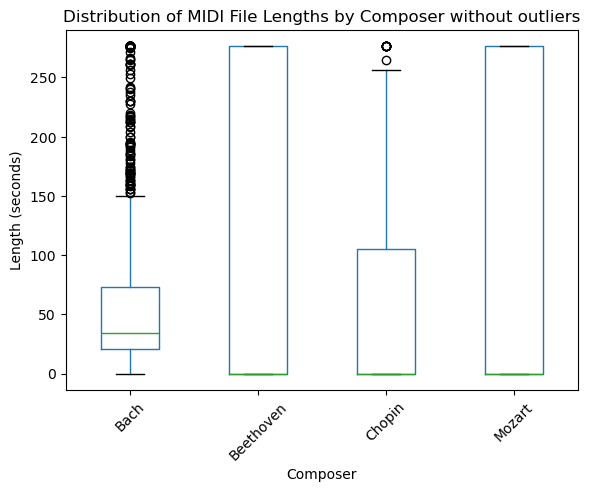

In [146]:
# Distribution of MIDI file lengths by composer after outlier removal
plt.figure(figsize=(12, 6))
df.boxplot(by='artist', column=['length'], grid=False)
plt.title('Distribution of MIDI File Lengths by Composer without outliers')
plt.suptitle('')
plt.xlabel('Composer')
plt.ylabel('Length (seconds)')
plt.xticks(rotation=45)
plt.show()

<Figure size 600x400 with 0 Axes>

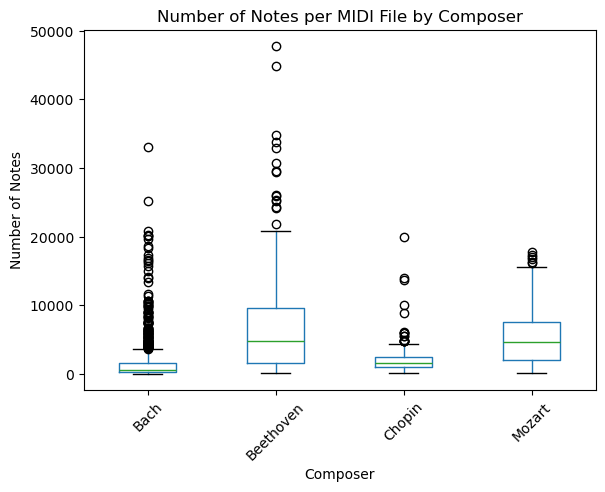

In [168]:
# Number of notes per MIDI file by composer
plt.figure(figsize=(6, 4))
df.boxplot(by='artist', column=['num_notes'], grid=False)
plt.title('Number of Notes per MIDI File by Composer')
plt.suptitle('')
plt.xlabel('Composer')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45)
plt.show()

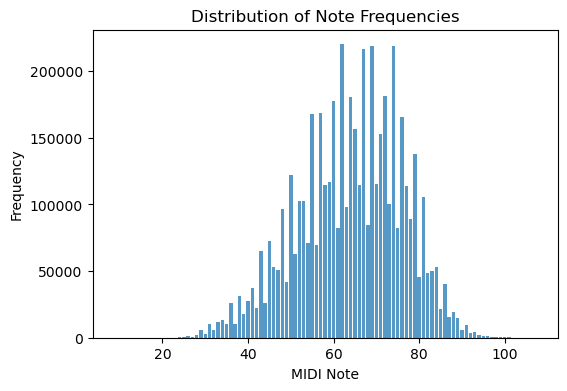

In [169]:
# Distribution of note frequencies
note_freqs = Counter()
for note_counter in df['note_freq']:
    note_freqs.update(note_counter)

plt.figure(figsize=(6, 4))
plt.bar(note_freqs.keys(), note_freqs.values(), alpha=0.75)
plt.title('Distribution of Note Frequencies')
plt.xlabel('MIDI Note')
plt.ylabel('Frequency')
plt.show()

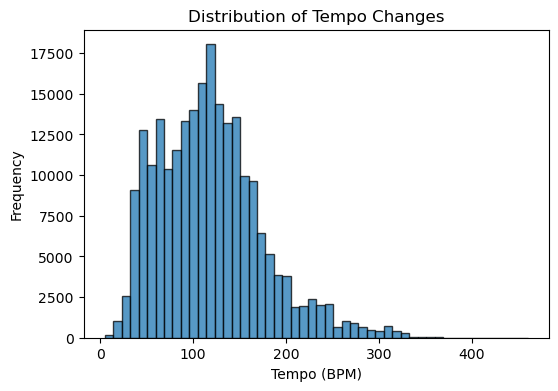

In [170]:
# Distribution of tempo changes
tempo_changes = [tempo for sublist in df['tempo_changes'] for tempo in sublist]

plt.figure(figsize=(6, 4))
plt.hist(tempo_changes, bins=50, alpha=0.75, edgecolor='black')
plt.title('Distribution of Tempo Changes')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.show()

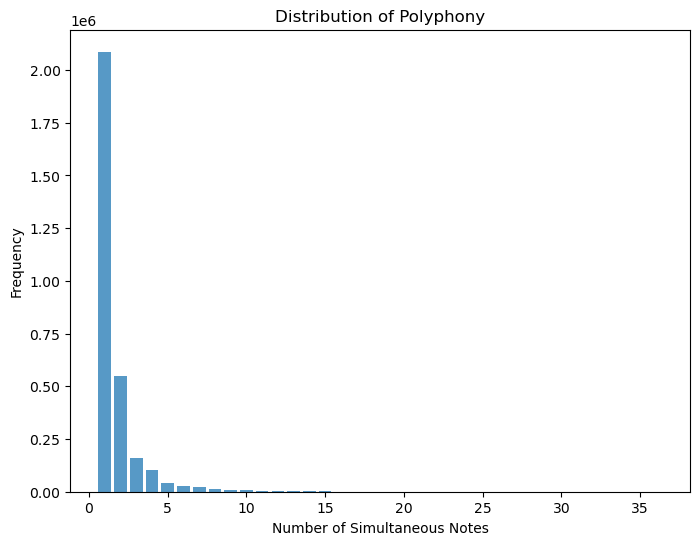

In [188]:
# Distribution of polyphony
polyphony_count = Counter()
for polyphony_counter in df['polyphony']:
    polyphony_count.update(polyphony_counter)

plt.figure(figsize=(8, 6))
plt.bar(polyphony_count.keys(), polyphony_count.values(), alpha=0.75)
plt.title('Distribution of Polyphony')
plt.xlabel('Number of Simultaneous Notes')
plt.ylabel('Frequency')
plt.show()

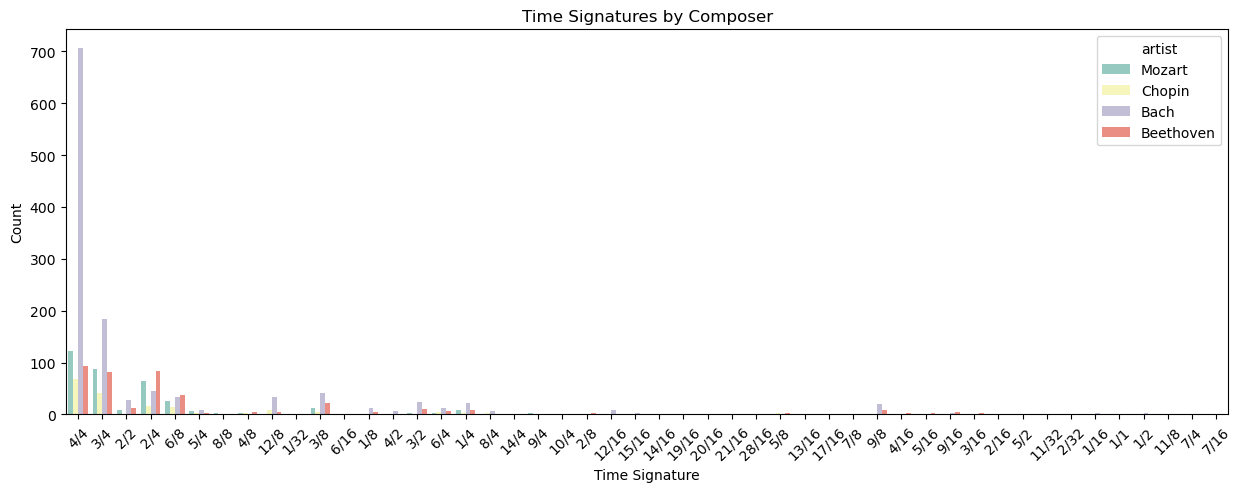

In [190]:
# Time signatures by composer
time_sigs_flat = []
for idx, row in df.iterrows():
    for time_sig, count in row['time_sigs'].items():
        time_sigs_flat.append({'artist': row['artist'], 'time_signature': f'{time_sig[0]}/{time_sig[1]}', 'count': count})

time_sigs_df = pd.DataFrame(time_sigs_flat)

plt.figure(figsize=(15, 5))
sns.countplot(data=time_sigs_df, x='time_signature', hue='artist', palette='Set3')
plt.title('Time Signatures by Composer')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

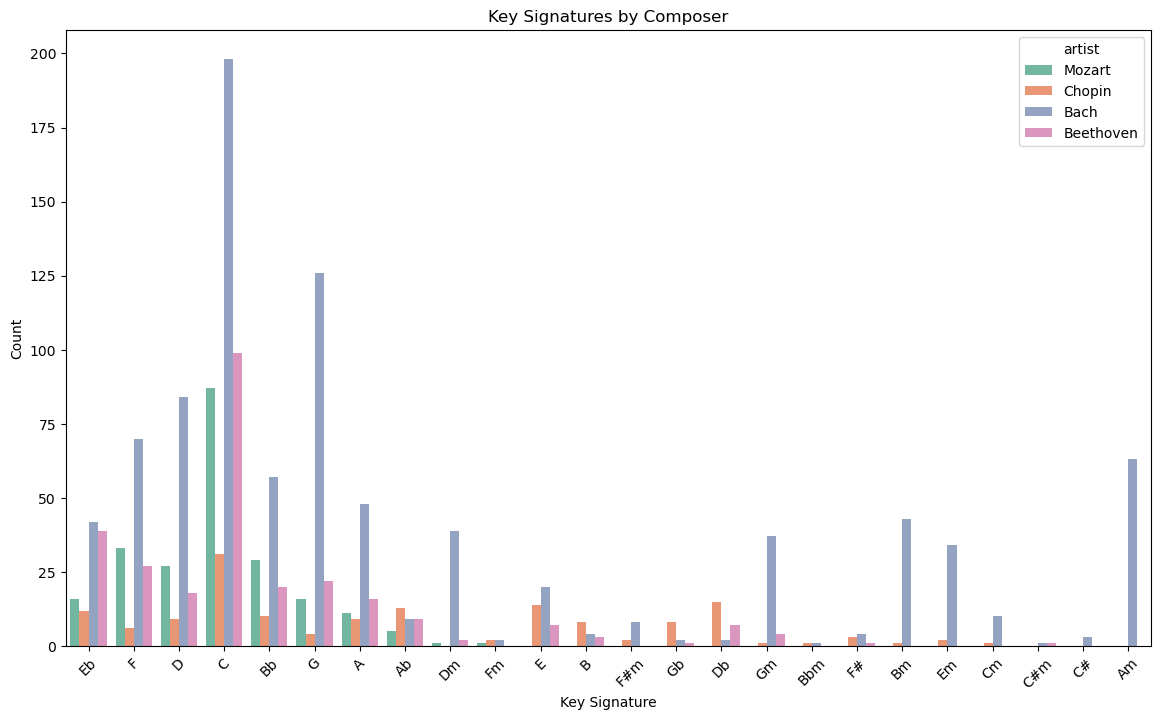

In [105]:
# Key signatures by composer
key_sigs_flat = []
for idx, row in df.iterrows():
    for key_sig, count in row['key_sigs'].items():
        key_sigs_flat.append({'artist': row['artist'], 'key_signature': key_sig, 'count': count})

key_sigs_df = pd.DataFrame(key_sigs_flat)

plt.figure(figsize=(14, 8))
sns.countplot(data=key_sigs_df, x='key_signature', hue='artist', palette='Set2')
plt.title('Key Signatures by Composer')
plt.xlabel('Key Signature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Ten Second Random Audio samples for each Composer

In [192]:
# Function to list MIDI files for a composer
def list_midi_files(directory, composer):
    composer_dir = os.path.join(directory, composer)
    return [os.path.join(composer_dir, file) for file in os.listdir(composer_dir) if file.endswith('.mid')]

# Function to play a MIDI file for a specified duration
def play_midi(file_path, duration=10):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    time.sleep(duration)
    pygame.mixer.music.stop()

# Dictionary to hold a randomly selected MIDI file for each composer
selected_files = {}

# Select one random MIDI file for each composer
for composer in composers:
    midi_files = list_midi_files(base_directory, composer)
    if midi_files:
        selected_files[composer] = random.choice(midi_files)
    else:
        print(f"No MIDI files found for {composer}")

# Play the selected MIDI files
for composer, file_path in selected_files.items():
    print(f"Playing {composer}'s selected MIDI file: {file_path}")
    play_midi(file_path)

Playing Bach's selected MIDI file: raw_data_unzipped/Bach/Bwv0536 Prelude and Fugue.mid
Playing Beethoven's selected MIDI file: raw_data_unzipped/Beethoven/Piano Concerto n5 op73 2-3mov ''Emperor''.mid
Playing Chopin's selected MIDI file: raw_data_unzipped/Chopin/Nocturne op15 n3.mid
Playing Mozart's selected MIDI file: raw_data_unzipped/Mozart/Adagio in B flat.mid


## Model Building